In [3]:
!which python
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak/experiments


In [4]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle

import numpy as np

import matplotlib.pyplot as plt

import utils
from utils import moving_average
from solve_binary_libsvm import solve_binary_libsvm
# from loss_functions import LogisticRegressionLoss, BaseOracle
from loss_functions import BaseOracle, LegacyLogisticRegressionLoss
from np_methods import BaseOptimizer, Adam, SLS

import sklearn
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split

import scipy
import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [240]:
def fn_booth(w):
    return (w[0] + 2 * w[1] - 7)**2 + (2 * w[0] + w[1] - 5)**2

def grad_booth(w):
    g = np.zeros_like(w)

    g[0] = 10 * w[0] + 8 * w[1] - 34
    g[1] = 8 * w[0] + 10 * w[1] - 38

    return g

class RosenbrockFunction:
    
    def func(self, x):
        out = 0.0
        for i in range(len(x) - 1):
            out += 100 * (x[i + 1] - x[i]**2)**2 + (1 - x[i])**2
        return out

    def grad(self, x):
        n = len(x)
        out = np.zeros_like(x)
        
        for i in range(n):
            if i == 0:
                out[i] = -400 * x[i] * (x[i + 1] - x[i]**2) - 2 * (1 - x[i])
            elif i == n - 1:
                out[i] = 200 * (x[i] - x[i-1]**2)
            else:
                out[i] = 200 * (x[i] - x[i-1]**2) - 400 * x[i] * (x[i+1] - x[i]**2) - 2 * (1 - x[i])

        return out
    
class RastriginFunction:

    def __init__(self, A: int = 10):
        self.A = A 

    def func(self, x):
        n = len(x)
        out = self.A * n

        for i in range(n):
            out += x[i]**2 - self.A * np.cos(2 * np.pi * x[i])
        
        return out 

    def grad(self, x):
        n = len(x)
        out = np.zeros_like(x)

        for i in range(n):
            out[i] = 2 * x[i] + 2 * self.A * np.pi * np.sin(2 * np.pi * x[i])

        return out


In [267]:
loss_fn = RastriginFunction()
w_star = [0, 0]

In [340]:
w_starting = [[4.5, -4.5], [-4.0, 0.0], [1.0, 1.0], [-4.0, 4.0]]

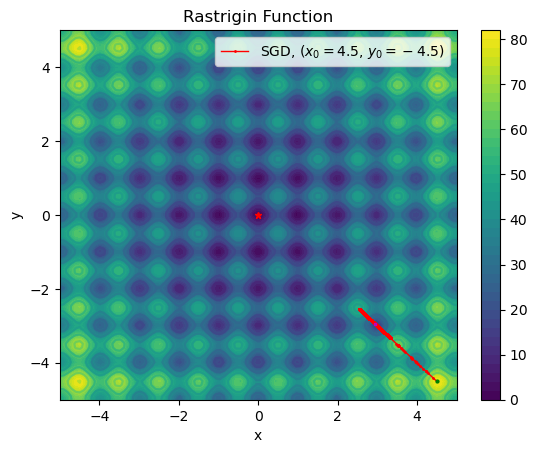

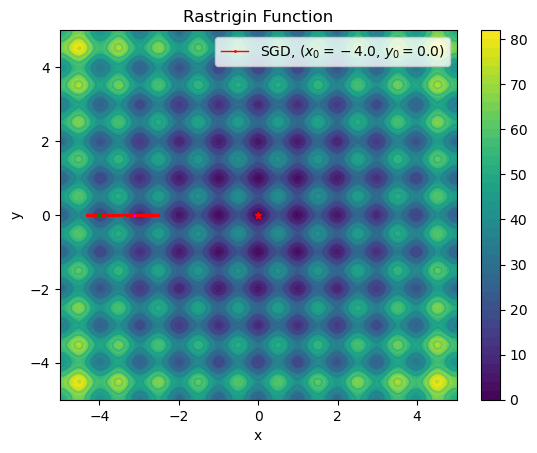

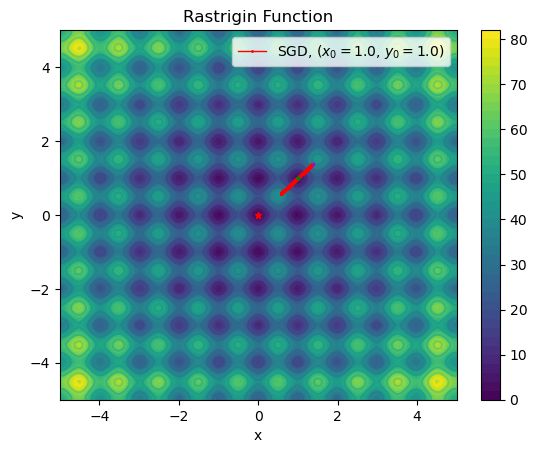

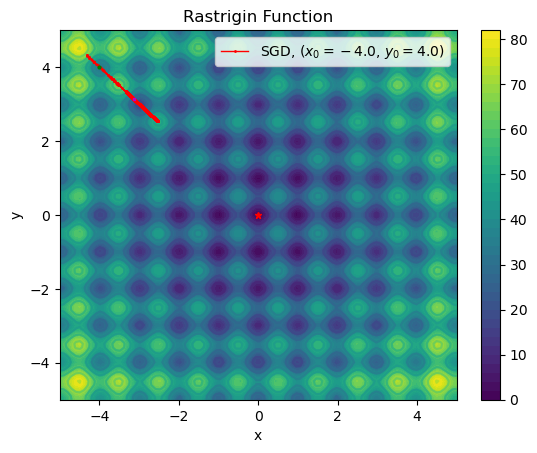

In [398]:

for w in w_starting:
    
    w_0 = w

    hist_sgd = []
    lr = 0.01

    for i in range(2000):
        hist_sgd.append(w)
        w = w - lr * loss_fn.grad(w)

    
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)

    X = np.meshgrid(x, y)
    Z = loss_fn.func(X)

    plt.figure()

    plt.contour(X[0], X[1], Z, 7)
    plt.contourf(X[0], X[1], Z, 50)
    plt.colorbar()

    plt.plot([i[0] for i in hist_sgd], [i[1] for i in hist_sgd], 
         'ro-', markersize=1, linewidth=1, 
         label=r'SGD, ($x_0={0}$, $y_0={1}$)'.format(w_0[0], w_0[1]))
    plt.plot(hist_sgd[0][0], hist_sgd[0][1], 'go', markersize=2)
    plt.plot(hist_sgd[-1][0], hist_sgd[-1][1], 'ms', markersize=2)

    plt.plot(w_star[0], w_star[1], 'r*', markersize=5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Rastrigin Function")

    plt.legend(loc='upper right')

    filename = f'rastrigin_sgd_{w_0}.pdf'
    directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(directory + "/" + filename)



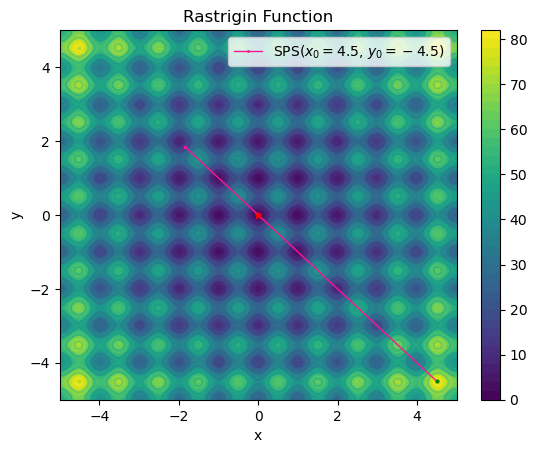

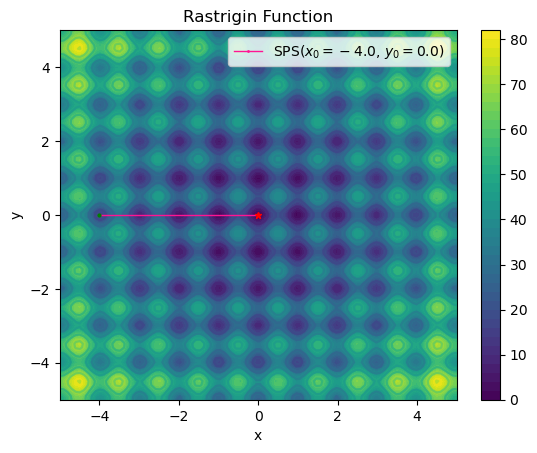

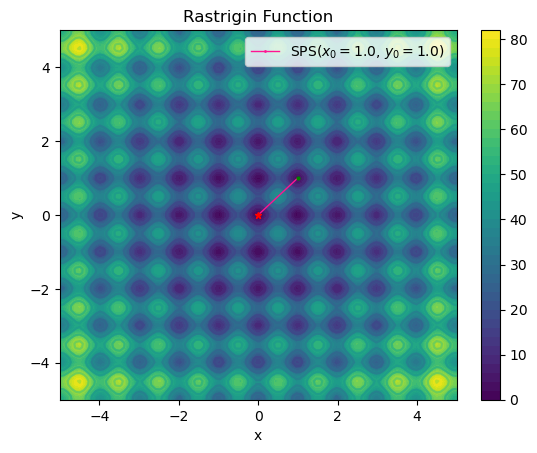

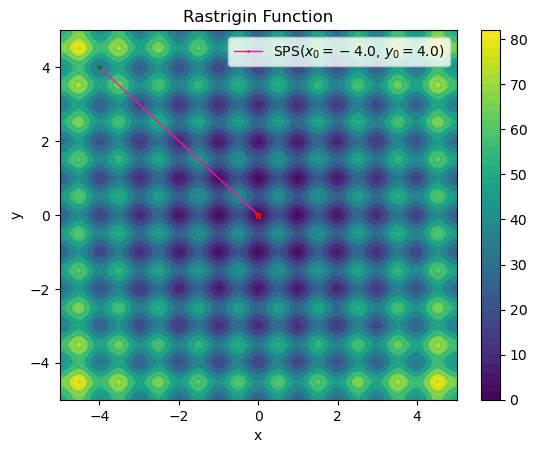

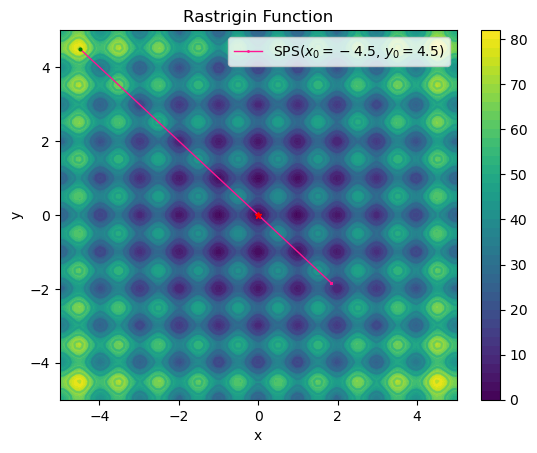

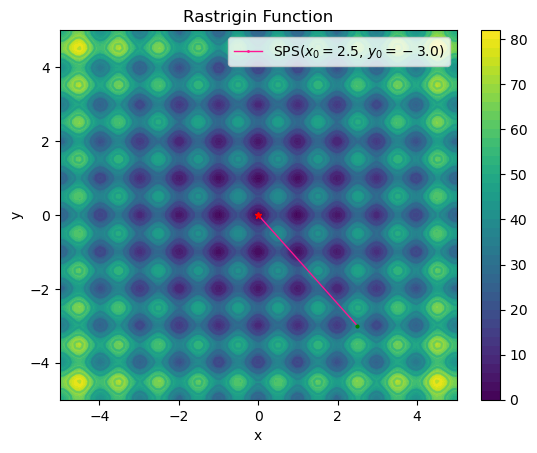

In [399]:

for w in w_starting + [[-4.5, 4.5], [2.5, -3.0]]:

    w_0 = w

    hist_sps = []

    for i in range(100):
        hist_sps.append(w)
        
        loss = loss_fn.func(w)
        g = loss_fn.grad(w)
        lr = loss / (0.5 * np.square(np.linalg.norm(g)) + 1e-10)
        # print(loss, lr)
        w -= lr * loss_fn.grad(w)
    
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)

    X = np.meshgrid(x, y)
    Z = loss_fn.func(X)
    
    plt.figure()
    
    plt.contour(X[0], X[1], Z, 7)
    plt.contourf(X[0], X[1], Z, 50)
    plt.colorbar()

    plt.plot([i[0] for i in hist_sps], [i[1] for i in hist_sps],
         'o-', color='deeppink', markersize=1, linewidth=1, 
         label=r'SPS($x_0={0}$, $y_0={1}$)'.format(w_0[0], w_0[1]))
    plt.plot(hist_sps[0][0], hist_sps[0][1], 'go', markersize=2)

    plt.plot(w_star[0], w_star[1], 'r*', markersize=5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Rastrigin Function")

    plt.legend(loc='upper right')

    # plt.show()
    filename = f'rastrigin_sps_{w_0}.pdf'
    directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(directory + "/" + filename)
    

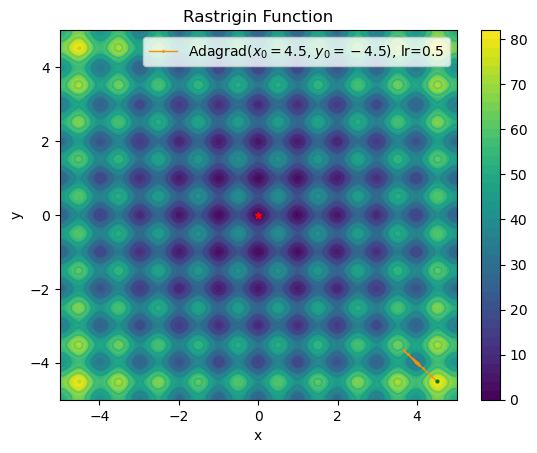

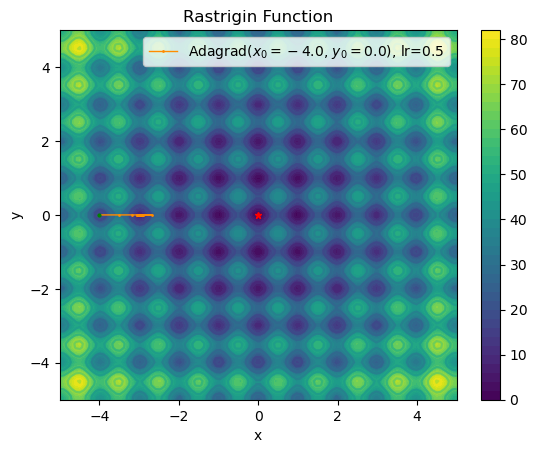

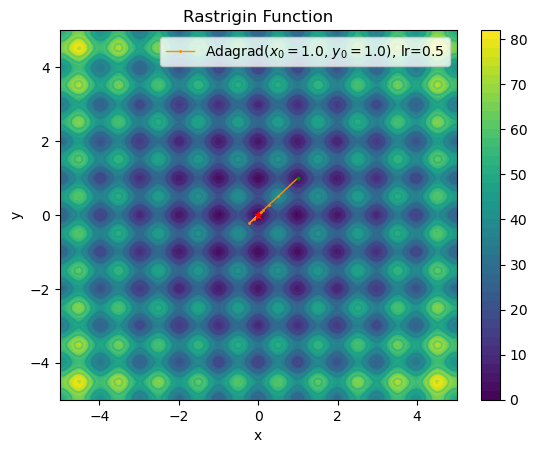

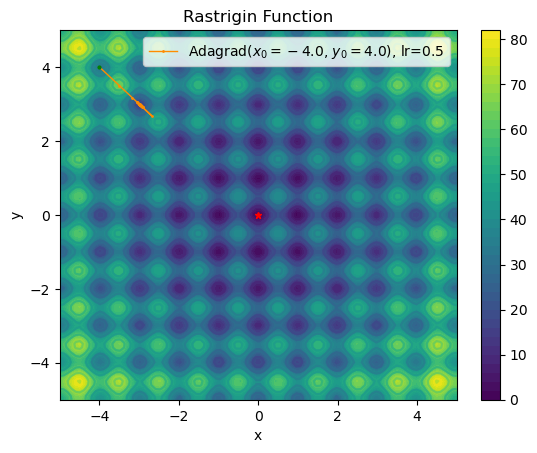

In [400]:
# w = [4.5, -4.5]

for w in [[4.5, -4.5], [-4.0, 0.0], [1.0, 1.0], [-4.0, 4.0]]:

    w_0 = w

    hist_adagrad = []

    grad_sum = np.zeros_like(w)

    lr = 0.5
    for i in range(2000):

        hist_adagrad.append(w)

        loss = loss_fn.func(w)
        grad = loss_fn.grad(w)

        grad_sum += np.square(grad)

        w = w - lr * (grad / (np.sqrt(grad_sum) + 1e-10))

    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)

    X = np.meshgrid(x, y)
    Z = loss_fn.func(X)

    plt.figure()

    plt.contour(X[0], X[1], Z, 7)
    plt.contourf(X[0], X[1], Z, 50)
    plt.colorbar()

    plt.plot([i[0] for i in hist_adagrad], [i[1] for i in hist_adagrad],
            'o-', color='darkorange', markersize=1, linewidth=1, 
            label=r'Adagrad($x_0={0}$, $y_0={1}$), lr={2}'.format(w_0[0], w_0[1], lr))
    
    plt.plot(hist_adagrad[0][0], hist_adagrad[0][1], 'go', markersize=2)

    plt.plot(w_star[0], w_star[1], 'r*', markersize=5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Rastrigin Function")

    plt.legend(loc='upper right')

    # plt.show()
    filename = f'rastrigin_adagrad_{w_0}.pdf'
    directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(directory + "/" + filename)


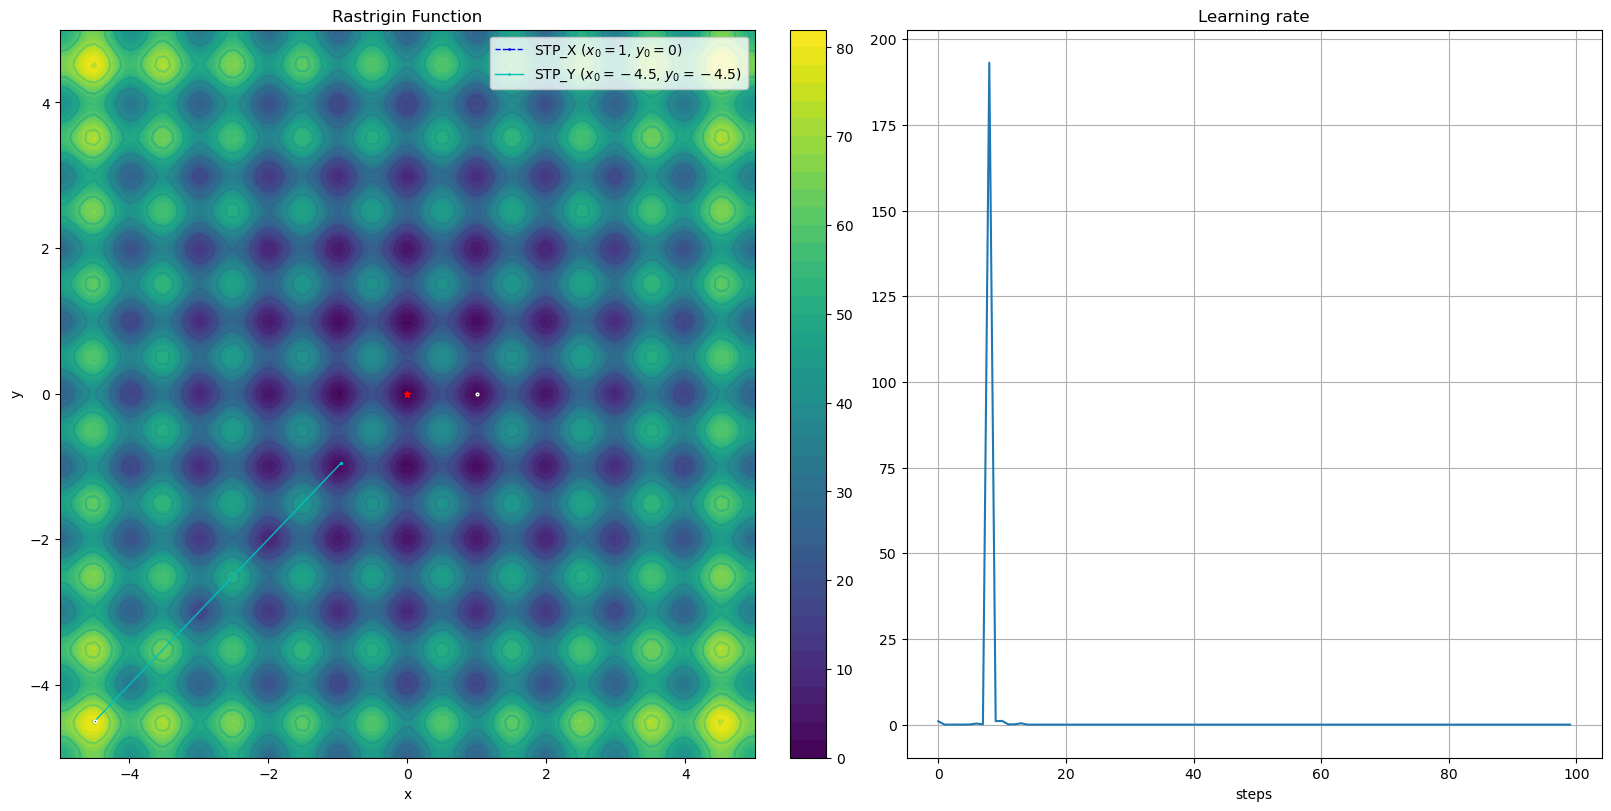

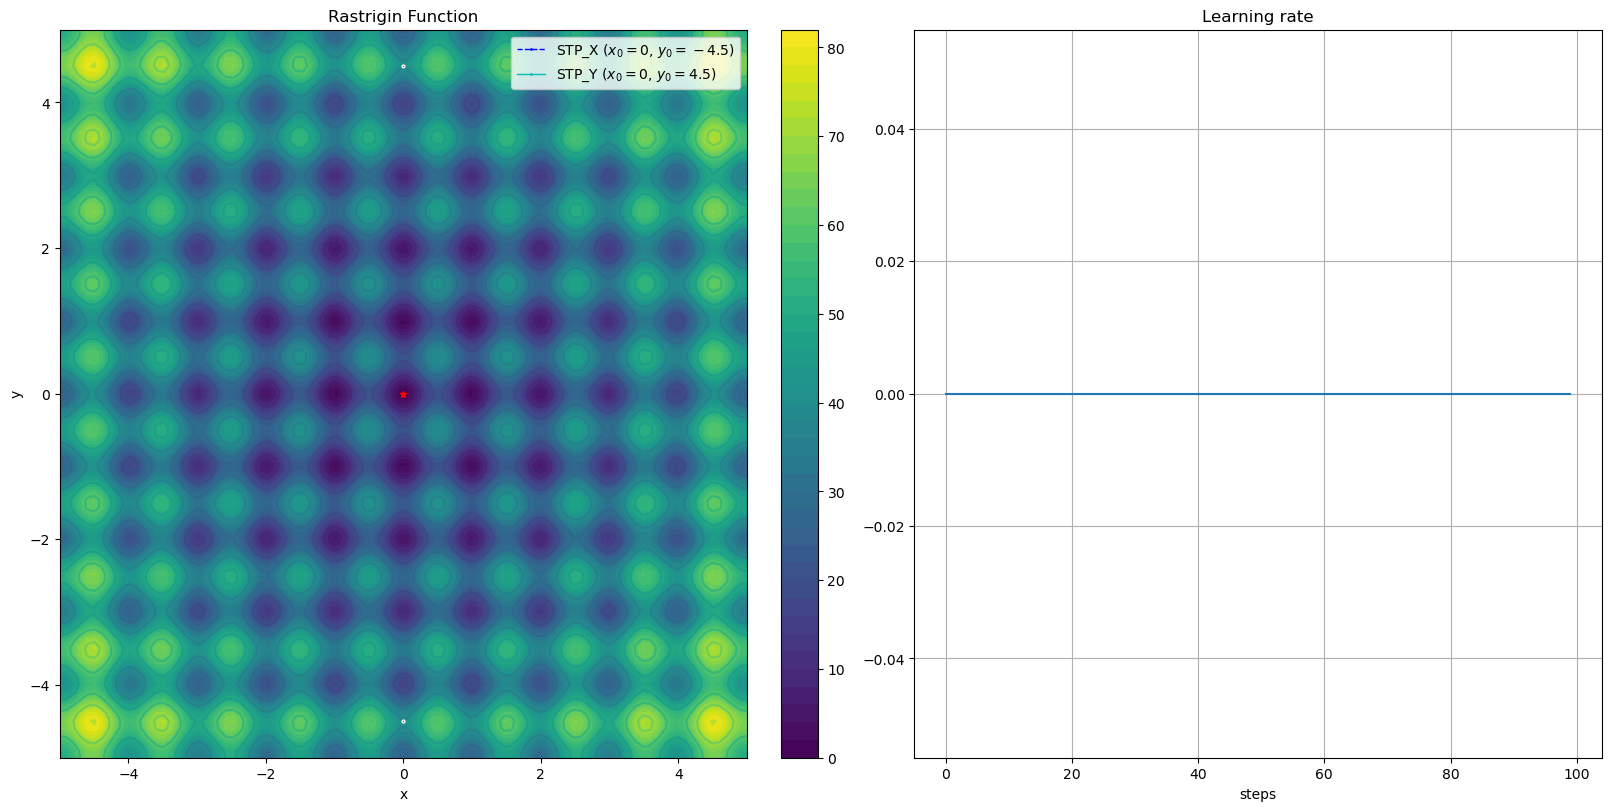

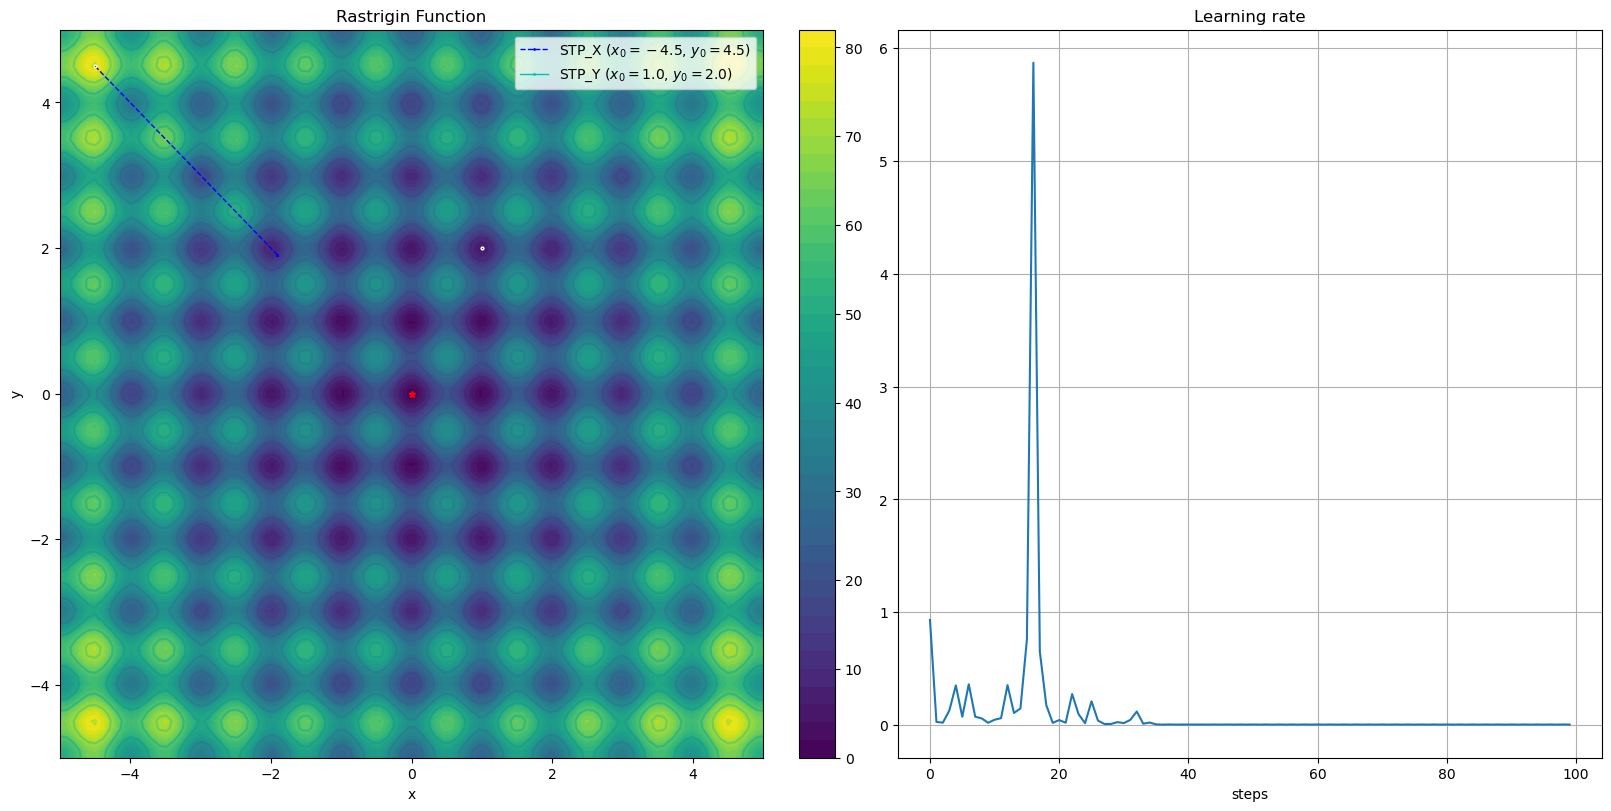

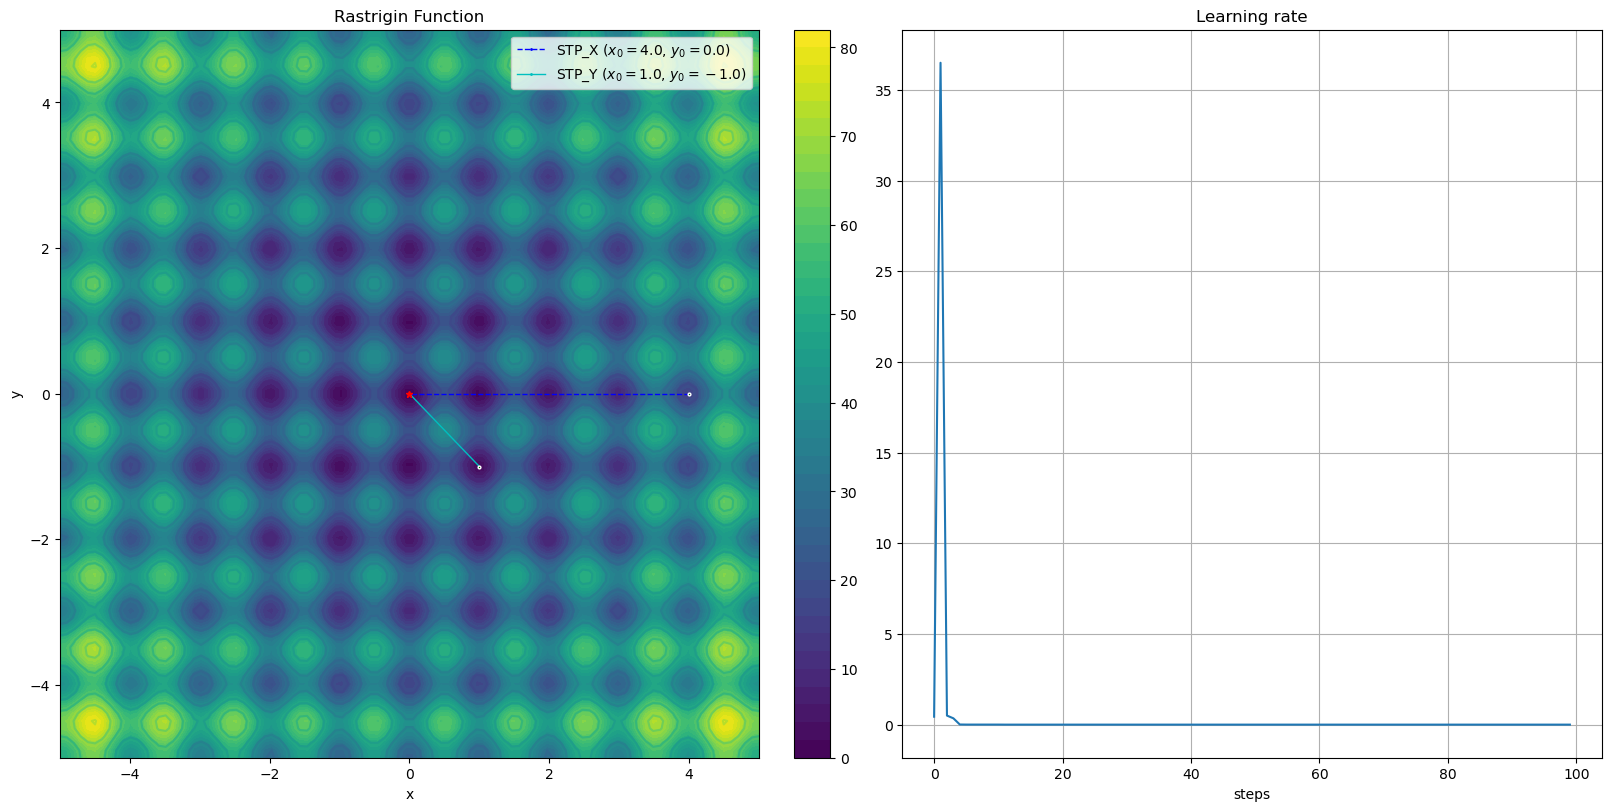

In [401]:
for w_x, w_y in [[[1, 0], [-4.5, -4.5]], 
                 [[0, -4.5], [0, 4.5]],
                 [[-4.5, 4.5], [1.0, 2.0]],
                 [[4.0, 0.0], [1.0, -1.0]]
                 ]:

    # w_x = [1, 0]
    # w_y = [-4.5, -4.5]

    w_x_0 = w_x
    w_y_0 = w_y

    hist_stp = defaultdict(list)

    for i in range(100):

        hist_stp['x'].append(w_x)
        hist_stp['y'].append(w_y)

        loss_x = loss_fn.func(w_x)
        grad_x = loss_fn.grad(w_x)

        loss_y = loss_fn.func(w_y)
        grad_y = loss_fn.grad(w_y)

        lr_x = (loss_x - loss_y) / (0.5 * np.linalg.norm(grad_x)**2 + 1e-10)
        lr_y = (loss_y - loss_x) / (0.5 * np.linalg.norm(grad_y)**2 + 1e-10)

        if loss_x > loss_y:
            w_x -= lr_x * grad_x
            lr = lr_x
        else:
            w_y -= lr_y * grad_y
            lr = lr_y
            
        hist_stp['lr'].append(lr)


    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)

    X = np.meshgrid(x, y)
    Z = loss_fn.func(X)

    fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(16, 8))

    axes[0].contour(X[0], X[1], Z, 7)
    ax1 = axes[0].contourf(X[0], X[1], Z, 50)
    fig.colorbar(ax1, ax=axes[0])

    axes[0].plot([i[0] for i in hist_stp['x']], [i[1] for i in hist_stp['x']], 
            'bo--', markersize=1, linewidth=1, 
            label=r'STP_X ($x_0={0}$, $y_0={1}$)'.format(w_x_0[0], w_x_0[1]))
    axes[0].plot(hist_stp['x'][0][0], hist_stp['x'][0][1], 'go', markersize=2, 
             markeredgecolor='white')

    axes[0].plot([i[0] for i in hist_stp['y']], [i[1] for i in hist_stp['y']], 
            'co-', markersize=1, linewidth=1, 
            label=r'STP_Y ($x_0={0}$, $y_0={1}$)'.format(w_y_0[0], w_y_0[1]))
    axes[0].plot(hist_stp['y'][0][0], hist_stp['y'][0][1], 'go', markersize=2,
             markeredgecolor='white')

    axes[0].plot(w_star[0], w_star[1], 'r*', markersize=5)

    axes[0].set_title("Rastrigin Function")
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')

    axes[0].legend()
    # plt.legend(loc='upper right')


    axes[1].plot(hist_stp['lr'])
    axes[1].set_title('Learning rate')
    axes[1].set_xlabel('steps')
    axes[1].grid()

    # plt.show()
    filename = f'rastrigin_stp_{w_x_0}_{w_y_0}.pdf'
    directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(directory + "/" + filename)

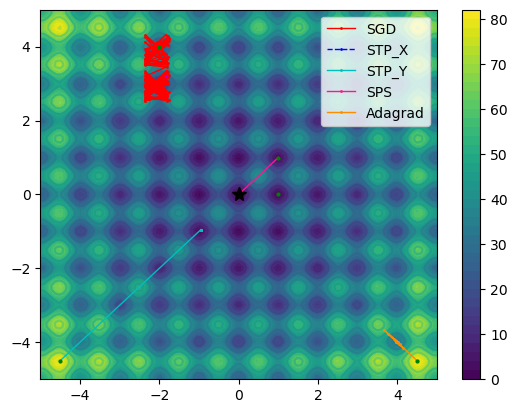

In [ ]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)

X = np.meshgrid(x, y)
Z = loss_fn.func(X)

plt.contour(X[0], X[1], Z, 7)
plt.contourf(X[0], X[1], Z, 50)
plt.colorbar()


plt.plot([i[0] for i in hist_sgd], [i[1] for i in hist_sgd], 
         'ro-', markersize=1, linewidth=1, label='SGD')
plt.plot(hist_sgd[0][0], hist_sgd[0][1], 'go', markersize=2)
plt.plot(hist_sgd[-1][0], hist_sgd[-1][1], 'ms', markersize=2)

plt.plot([i[0] for i in hist_stp['x']], [i[1] for i in hist_stp['x']], 
         'bo--', markersize=1, linewidth=1, label='STP_X')
plt.plot(hist_stp['x'][0][0], hist_stp['x'][0][1], 'go', markersize=2)
# plt.plot(hist_stp['x'][-1][0], hist_stp['x'][-1][1], 'mo', markersize=2)

plt.plot([i[0] for i in hist_stp['y']], [i[1] for i in hist_stp['y']], 
         'co-', markersize=1, linewidth=1, label='STP_Y')
plt.plot(hist_stp['y'][0][0], hist_stp['y'][0][1], 'go', markersize=2)
# plt.plot(hist_stp['y'][-1][0], hist_stp['y'][-1][1], 'mo', markersize=2)

plt.plot([i[0] for i in hist_sps], [i[1] for i in hist_sps],
         'o-', color='deeppink', markersize=1, linewidth=1, label='SPS')
plt.plot(hist_sps[0][0], hist_sps[0][1], 'go', markersize=2)

plt.plot([i[0] for i in hist_adagrad], [i[1] for i in hist_adagrad],
         'o-', color='darkorange', markersize=1, linewidth=1, label='Adagrad')
plt.plot(hist_adagrad[0][0], hist_adagrad[0][1], 'go', markersize=2)


plt.plot(w_star[0], w_star[1], 'k*', markersize=10, )

plt.legend(loc='upper right')

plt.show()

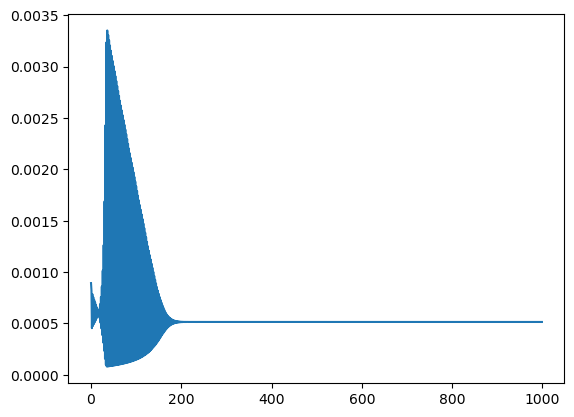

In [159]:
plt.plot(hist_stp['lr'])

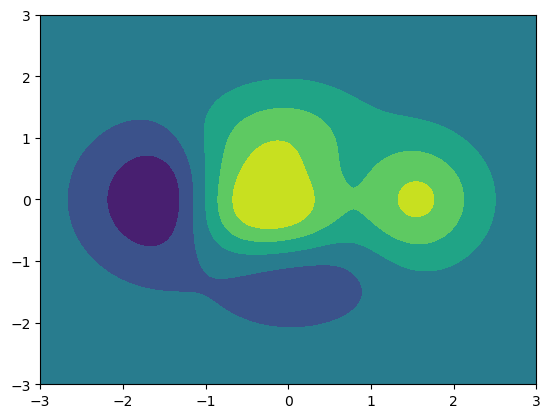

In [5]:
# make data
X, Y = np.meshgrid(np.linspace(-3, 3, 256), np.linspace(-3, 3, 256))
Z = (1 - X/2 + X**5 + Y**3) * np.exp(-X**2 - Y**2)
levels = np.linspace(Z.min(), Z.max(), 7)

# plot
fig, ax = plt.subplots()

ax.contourf(X, Y, Z, levels=levels)

plt.show()

In [164]:
import sklearn.model_selection


np.random.seed(0)
n = 5_000
d = 100
dataset_name = "synthetic-interpolation"

data, target = sklearn.datasets.make_classification(n_samples=n, n_features=d, n_redundant=0, n_clusters_per_class=1, class_sep=3.0, random_state=0)
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(data, target, test_size=0.2, random_state=0)

train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
test_target = utils.map_classes_to(test_target, [-1.0, 1.0])

L = (0.25 / train_data.shape[0]) * np.linalg.norm(train_data.T @ train_data, ord=2)

# batch_size = train_data.shape[0]
batch_size = 100

print(f"{L=}")
print(f"{1/L=}")
print(f"{np.unique(train_target)=}")

oracle = LogisticRegressionLoss()
w = np.random.randn(train_data.shape[1])
train_result = scipy.optimize.minimize(
        fun=oracle.func,
        jac=oracle.grad,
        x0=w,
        args=(train_data, train_target),
        method="L-BFGS-B"
    )

test_result = scipy.optimize.minimize(
    fun=oracle.func,
    jac=oracle.grad,
    x0=w,
    args=(test_data, test_target),
    method="L-BFGS-B"
)
    
b = {
    "dataset_name": dataset_name,
    "train/f_star": oracle.func(train_result.x, train_data, train_target),
    "test/f_star": oracle.func(test_result.x, test_data, test_target),
    "train/x_star": train_result.x,
    "test/x_star": test_result.x
}

    
train_f_star, train_x_star, test_f_star, test_x_star = b["train/f_star"], b["train/x_star"], b["test/f_star"], b["test/x_star"]
print(f"{train_f_star=}")
print(f"{test_f_star=}")

dataset = train_data, train_target, test_data, test_target

L=2.4476005045688796
1/L=0.40856340654176326
np.unique(train_target)=array([-1.,  1.])
train_f_star=0.013058385251705279
test_f_star=3.7758441795178194e-06


In [12]:
np.random.seed(0)
n = 2000
d = 100
dataset_name = "synthetic-no-interpolation"

data, target = sklearn.datasets.make_classification(n_samples=n, n_features=d, n_redundant=0, n_clusters_per_class=2, class_sep=0.1, random_state=0)
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(data, target, test_size=0.2, random_state=0)

train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
test_target = utils.map_classes_to(test_target, [-1.0, 1.0])


L = (0.25 / train_data.shape[0]) * np.linalg.norm(train_data.T.dot(train_data), ord=2)

# batch_size = train_data.shape[0]
batch_size = 100

print(f"{L=}")
print(f"{1/L=}")
print(f"{np.unique(train_target)=}")

dataset = train_data, train_target, test_data, test_target

L=0.3813798712150801
1/L=2.622057626727887
np.unique(train_target)=array([-1.,  1.])


In [ ]:
dataset_name = "mushrooms"
trainX, trainY, testX, testY = utils.get_libsvm(dataset_name, test_split=0.0)

trainY = utils.map_classes_to(trainY, [-1.0, 1.0])
testY = utils.map_classes_to(testY, [-1.0, 1.0])

train_data, train_target = sklearn.preprocessing.normalize(trainX, norm='l2', axis=1), trainY
test_data, test_target = sklearn.preprocessing.normalize(testX, norm='l2', axis=1), testY

b = solve_binary_libsvm(train_data, train_target, test_data, test_target)
train_f_star, train_x_star, test_f_star, test_x_star = b["train/f_star"], b["train/x_star"], b["test/f_star"], b["test/x_star"]

L = (0.25 / train_data.shape[0]) * scipy.sparse.linalg.norm(train_data.T @ train_data, ord=2)

dataset = train_data, train_target, test_data, test_target

# batch_size = train_data.shape[0]
batch_size = 10
setting = "Deterministic" if batch_size == train_data.shape[0] else "Stochastic"

print(f"{train_f_star=}")
print(f"{test_f_star=}")
print(f"{1/L=}")
print(f"{batch_size=}")
print(f"{train_data.shape=}, {test_data.shape=}")
print(f"{np.unique(train_target)=}, {np.unique(test_target)=}")

train_f_star=0.0005205630857871723
test_f_star=0.0005205630857871723
1/L=27.405113829384963
batch_size=10
train_data.shape=(62, 2000), test_data.shape=(62, 2000)
np.unique(train_target)=array([-1.,  1.]), np.unique(test_target)=array([-1.,  1.])


In [238]:
class NumpyDataLoader:

    def __init__(self, X, y, batch_size: int, shuffle: bool = True, drop_last: bool = False):

        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last

        assert self.X.shape[0] == len(self.y), "X and y must have the same number of samples"

    def __iter__(self):
        self.indices = np.arange(self.X.shape[0])
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.current_idx = 0
        return self

    def __next__(self):
        if self.current_idx >= self.X.shape[0]:
            raise StopIteration
        
        batch_indices = self.indices[self.current_idx:self.current_idx + self.batch_size]
        if self.drop_last and len(batch_indices) < self.batch_size:
            raise StopIteration
        
        batch_X = self.X[batch_indices]
        batch_y = self.y[batch_indices]

        self.current_idx += self.batch_size
        return batch_X, batch_y
    
    def __len__(self):
        if self.drop_last:
            return self.X.shape[0] // self.batch_size
        else:
            return (self.X.shape[0] + self.batch_size - 1) // self.batch_size
        

import sklearn.preprocessing
import sklearn.datasets

class ColonCancerNumpyDataModule:
    
    def __init__(self, data_dir: str = os.getenv("LIBSVM_DIR"), batch_size: int = 8):
        super().__init__()

        self.batch_size: int = batch_size
        self.num_samples: int = 62
        self.num_features: int = 2000
        self.num_labels: int = 2
        
        data, target = sklearn.datasets.load_svmlight_file(f'{data_dir}/colon-cancer', n_features=self.num_features)
        data = sklearn.preprocessing.normalize(data, norm='l2', axis=1)
        target = utils.map_classes_to(target, [-1.0, 1.0])

        assert np.all(np.sort(np.unique(target)) == [-1.0, 1.0])

        self.train_dataloader = NumpyDataLoader(data, target, batch_size=self.batch_size, shuffle=True, drop_last=False)
        self.val_dataloader = NumpyDataLoader(data, target, batch_size=self.num_samples, shuffle=False, drop_last=False) # `batch_size` == dataset size because it is a small dataset

class MushroomsNumpyDataModule:
    
    def __init__(self, data_dir: str = os.getenv("LIBSVM_DIR"), batch_size: int = 8):
        super().__init__()

        self.batch_size: int = batch_size
        self.num_samples: int = 8124
        self.num_features: int = 112
        self.num_labels: int = 2
        
        data, target = sklearn.datasets.load_svmlight_file(f'{data_dir}/mushrooms', n_features=self.num_features)
        data = sklearn.preprocessing.normalize(data, norm='l2', axis=1)
        target = utils.map_classes_to(target, [-1.0, 1.0])

        assert np.all(np.sort(np.unique(target)) == [-1.0, 1.0])

        self.train_dataloader = NumpyDataLoader(data, target, batch_size=self.batch_size, shuffle=True, drop_last=False)
        self.val_dataloader = NumpyDataLoader(data, target, batch_size=self.num_samples, shuffle=False, drop_last=False) # `batch_size` == dataset size because it is a small dataset




In [ ]:
np.random.seed(0)
data_module = ColonCancerNumpyDataModule(batch_size=8)

for i in range(2):
    for x, y in data_module.train_dataloader:
        print(i, x[:2].todense())
        break

np.random.seed(0)
data_module = ColonCancerNumpyDataModule(batch_size=8)

for i in range(2):
    for x, y in data_module.train_dataloader:
        print(i, x[:2].todense())
        break

0 [[-0.01248521  0.01490041  0.01729414 ...  0.01053862  0.01139473
   0.0226272 ]
 [ 0.01676169 -0.03015524 -0.02576244 ... -0.00605133  0.0324973
   0.0036554 ]]
1 [[-0.00638845 -0.0443723  -0.0468008  ...  0.02540076  0.01715498
   0.00115003]
 [ 0.00429121 -0.01429387 -0.02001078 ...  0.01293563  0.02875494
  -0.05313221]]
0 [[-0.01248521  0.01490041  0.01729414 ...  0.01053862  0.01139473
   0.0226272 ]
 [ 0.01676169 -0.03015524 -0.02576244 ... -0.00605133  0.0324973
   0.0036554 ]]
1 [[-0.00638845 -0.0443723  -0.0468008  ...  0.02540076  0.01715498
   0.00115003]
 [ 0.00429121 -0.01429387 -0.02001078 ...  0.01293563  0.02875494
  -0.05313221]]


In [162]:
data, target = train_data, train_target

w = np.random.randn(train_data.shape[1])

loss = LogisticRegressionLoss()

logits = data @ w
loss.loss(logits, target), np.linalg.norm(loss.grad(logits, data, target)), np.linalg.norm(loss.hess(logits, data, target))

(0.8281145705135607, 0.1334682775735651, 0.04579448989839057)

In [20]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, markeredgecolor=None, markersize=8,
            alphas=None, f_star=None, suptitle=None, prefix="train",
            x_labels=None, y_labels=None,
            threshold=1e-10, xlims=None, apply_ma=True,
            tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
    
    if alphas is None:
        alphas = [1.0 for x in histories]

    ma_factor = lambda x: x // 20 if apply_ma else 0
        
    for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):
        if not f_star:
            f_suboptim = history[f"{prefix}/loss"]
        else:
            f_suboptim = history[f"{prefix}/loss"] - f_star
        
        f_suboptim = moving_average(f_suboptim, ma_factor(len(f_suboptim)))

        try:
            markevery = [0, ] + [x + np.random.randint(0, 5) for x in range(0, len(history[f"{prefix}/loss"]) - 5, len(history[f"{prefix}/loss"]) // 10)]
        except:
            markevery = []
        
        ax[0].semilogy(f_suboptim, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        res = history[f"{prefix}/grad_norm_sq"]
        res = moving_average(res, ma_factor(len(res)))
        ax[1].semilogy(res, linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        ax[2].plot(history[f"test/acc"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        try:
            markevery = [0, ] + [x + np.random.randint(0, 5) for x in range(0, len(history["lr"]) - 5, len(history["lr"]) // 5)]
        except:
            markevery = []
        
        res = history["lr"]
        res = moving_average(res, ma_factor(len(res)))
        if alpha != 1.0:
            ax[3].semilogy(res, linestyle=ls, linewidth=lw, color=c, alpha=alpha)
            ax[3].semilogy(moving_average(res, ma_factor(len(f_suboptim))), linestyle=ls, linewidth=lw, color=c, alpha=1.0, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        else:
            ax[3].semilogy(res, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)

    if f_star == 0.0:
        ax[0].set_ylabel(r"$f(x_k)$")
        ax[1].set_ylabel(r"$\| \nabla f(x_k) \|^2$")
    else:
        ax[0].set_ylabel(r"$f(x_k) - f^*$")
        ax[1].set_ylabel(r"$\| \nabla f(x_k) \|^2$")
        
    ax[2].set_ylabel("Test Accuracy")
    ax[3].set_ylabel("step-size")
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[2].set_xlabel("Epochs")
    ax[3].set_xlabel("Steps")
    
    # ax[3].tick_params(axis='x', rotation=45)


    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])
    
    fig.legend()

    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[3].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()

In [203]:
class STP(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, 
                 beta: float = 0.9,
                 eps: float = 1e-8):
        
        self.params = params
        self.beta = beta
        self.eps = eps
        
        self.defaults = dict(
            beta=beta,
            eps=eps,
            )
        
        self.f_ma = 0.0
        self.g_ma = np.zeros_like(params)
        self.gamma_ma = 0.0

    def step(self, loss_diff):

        self.lr = loss_diff / (0.5 * np.square(np.linalg.norm(self.g_ma)) + self.eps) 
        self.params -= self.lr * self.g_ma
            
    def momentum_step(self, loss, grad):

        self.f_ma = self.beta * self.f_ma + (1 - self.beta) * loss
        self.gamma_ma = self.beta * self.gamma_ma + (1 - self.beta) * np.dot(grad, self.params)
        self.g_ma = self.beta * self.g_ma + (1 - self.beta) * grad
        h = self.f_ma + np.dot(self.g_ma, self.params) - self.gamma_ma

        return h


In [273]:
from collections import defaultdict

class NumpyLogger:

    def __init__(self):
        self.current_storage = defaultdict(list)
        self.storage = defaultdict(list)

    def __getitem__(self, key):
        return self.storage[key]

    def log(self, name, value, on_epoch: bool = True):
        if on_epoch:
            self.current_storage[name].append(value)
        else:
            self.storage[name].append(value)
    
    def compute_on_epoch(self):
        for key, values in self.current_storage.items():
            self.storage[key].append(np.mean(values))

    def reset(self):
        self.current_storage.clear()
    


In [274]:
class LogisticRegressionLoss(BaseOracle):
    
    def __init__(self, lmd: float = 0.0) -> None:
        self.lmd = lmd
   
    def loss(self, logits, y, w = None):
        reg_term = 0.0
        if self.lmd > 0.0:
            if w:
                reg_term = 0.5 * self.lmd * np.linalg.norm(w)**2
        loss_val = np.mean(np.logaddexp(0, -y * logits))
        return loss_val + reg_term
    
    def grad(self, logits, X, y, w = None):
        s = self._sigmoid(-y * logits)
        
        reg_term = 0.0
        if self.lmd > 0.0:
            if w:
                reg_term = self.lmd * w
            else:
                raise ValueError("Provide model parameters `w` for computing regularization term.")

        grad_val = (X.T @ (-y * s)) / X.shape[0]
        return grad_val + reg_term
    
    def _sigmoid(self, z):
        return np.where(
                z >= 0,
                1 / (1 + np.exp(-z)),
                np.exp(z) / (1 + np.exp(z))
            )
    
class LogisticRegressionAccuracy:

    def __call__(self, logits, targets):
        preds = np.where(logits > 0, 1, -1)
        return np.mean(preds == targets)

class NumpyLinearModel:
    def __init__(self, input_dim: int):
        self.params = np.random.randn(input_dim)

    def __call__(self, X):
        return X @ self.params
    
    def parameters(self):
        return self.params

class NumpyBaseTrainingModule:

    def __init__(self, 
                 max_epochs: int):
        
        self.max_epochs = max_epochs
        self.logger = NumpyLogger()

        self.current_epoch = 0
        self.current_step = 0

    def build_model(self):
        raise NotImplementedError()

    def define_loss_fn(self):
        raise NotImplementedError()

    def fit(self, datamodule):
        
        for epoch in range(self.max_epochs):
            
            self.current_epoch = epoch
            
            self.logger.reset()    
            
            for batch in datamodule.train_dataloader:
                self.training_step(batch)

            for batch in datamodule.val_dataloader:
                self.validation_step(batch)

            self.logger.compute_on_epoch()


    def training_step(self, batch):
        raise NotImplementedError()

    def validation_step(self, batch):
        raise NotImplementedError()

    def configure_optimizers(self):
        raise NotImplementedError()

class NumpyLibSVMBinaryClassifier(NumpyBaseTrainingModule):

    def __init__(self, 
                 input_dim,
                 config,
                 max_epochs):
        super().__init__(max_epochs)

        self.config = config
        self.model = self.build_model(input_dim)
        self.optimizer = self.configure_optimizers()
        self.loss_function = self.define_loss_fn()
        self.metric_accuracy = LogisticRegressionAccuracy()

        if self.config['optimizer'] is STP:
            self.logger.log('model_x', self.model[0].params.copy(), on_epoch=False)
            self.logger.log('model_y', self.model[1].params.copy(), on_epoch=False)

    def define_loss_fn(self):
        return LogisticRegressionLoss(self.config.get('lmd', 0.0))

    def build_model(self, input_dim):
        if self.config['optimizer'] is STP:
            return [
                NumpyLinearModel(input_dim=input_dim),
                NumpyLinearModel(input_dim=input_dim)
            ]
        else:
            return NumpyLinearModel(input_dim=input_dim)

    def training_step(self, batch):
        X, y = batch

        if self.config['optimizer'] is STP:
        
            logits_x = self.model[0](X)
            logits_y = self.model[1](X)

            loss_x = self.loss_function.loss(logits_x, y, w=self.model[0].params)
            grad_x = self.loss_function.grad(logits_x, X, y, w=self.model[0].params)
        
            loss_y = self.loss_function.loss(logits_y, y, w=self.model[1].params)
            grad_y = self.loss_function.grad(logits_y, X, y, w=self.model[1].params)

            h_x = self.optimizer[0].momentum_step(loss_x, grad_x)
            h_y = self.optimizer[1].momentum_step(loss_y, grad_y)
            
            if h_x > h_y:
                loss_diff = h_x - h_y
                self.optimizer[0].step(loss_diff)
                self.logger.log('train_loss', loss_y, on_epoch=True)
                self.logger.log('lr', self.optimizer[0].lr, on_epoch=False)
            else:
                loss_diff = h_y - h_x 
                self.optimizer[1].step(loss_diff)
                self.logger.log('train_loss', loss_x, on_epoch=True)
                self.logger.log('lr', self.optimizer[1].lr, on_epoch=False)

        else:
            logits = self.model(X)

            loss = self.loss_function.loss(logits, y, w=self.model.params)
            grad = self.loss_function.grad(logits, X, y, w=self.model.params)
            
            if self.config['optimizer'] is SLS:
                    def closure(params):
                        return self.loss_function.loss(logits, y, w=params)
                    self.optimizer.step(loss, grad, closure=closure)
            else:
                self.optimizer.step(loss, grad)

            self.logger.log('train_loss', loss, on_epoch=True)
            self.logger.log('lr', self.optimizer.lr, on_epoch=False)
        
    def validation_step(self, batch):
        X, y = batch
        
        if self.config['optimizer'] is STP:
            logits_x = self.model[0](X)
            logits_y = self.model[1](X)

            loss_x = self.loss_function.loss(logits_x, y, w=self.model[0].params)
        
            loss_y = self.loss_function.loss(logits_y, y, w=self.model[1].params)
            
            if loss_x < loss_y:
                loss = loss_x 
                acc = self.metric_accuracy(logits_x, y)
            else:
                loss = loss_y 
                acc = self.metric_accuracy(logits_y, y)

        else:
            logits = self.model(X)

            loss = self.loss_function.loss(logits, y, w=self.model.params)
            acc = self.metric_accuracy(logits, y)
        
        self.logger.log('val_loss', loss)
        self.logger.log('val_acc', acc)

    def configure_optimizers(self):
        optimizer_hparams = self.config['optimizer_hparams']
        print(optimizer_hparams)
        if self.config['optimizer'] is STP:
            return [
                STP(self.model[0].params, **optimizer_hparams),
                STP(self.model[1].params, **optimizer_hparams)
            ]
        else:
            return self.config['optimizer'](self.model.params, **optimizer_hparams)

In [275]:
config = {
    'batch_size': 16,
    'max_epochs': 100,
    'optimizer': STP,
    'optimizer_hparams': {
        'beta': 0.9,
        'eps': 1e-8,
    }
}

seed = 1
np.random.seed(seed)
datamodule = ColonCancerNumpyDataModule(batch_size=config['batch_size'])
classifier = NumpyLibSVMBinaryClassifier(input_dim=datamodule.num_features,
                                   config=config, 
                                   max_epochs=config['max_epochs'])
classifier.fit(datamodule=datamodule)

{'beta': 0.9, 'eps': 1e-08}


In [278]:
import pandas as pd

classifier.logger.storage

df = pd.DataFrame(classifier.logger.storage)

df.head()

ValueError: All arrays must be of the same length

In [258]:
np.random.seed(seed)
datamodule2 = ColonCancerNumpyDataModule(batch_size=config['batch_size'])

hist_tp_old = twin_polyak_ma(
    datamodule=datamodule2,
    n_epochs=config['max_epochs'],
    seed=seed,
    beta=config['optimizer_hparams']['beta']
)


NEW


In [261]:
classifier.logger['model_y'][0][:10], hist_tp_old['model_y'][0][:10]

(array([ 0.48951662,  0.23879586, -0.44811181, -0.610795  , -2.02994507,
         0.60794659, -0.35410888,  0.15258149,  0.50127485, -0.78640277]),
 array([ 0.48951662,  0.23879586, -0.44811181, -0.610795  , -2.02994507,
         0.60794659, -0.35410888,  0.15258149,  0.50127485, -0.78640277]))

In [242]:
config = {
    'batch_size': 16,
    'max_epochs': 100,
    'optimizer': Adam,
    'optimizer_hparams': {
        'lr': 0.1,
    }
}

np.random.seed(seed)
datamodule = ColonCancerNumpyDataModule(batch_size=config['batch_size'])

classifier_adam = NumpyLibSVMBinaryClassifier(input_dim=datamodule.num_features,
                                   config=config, 
                                   max_epochs=config['max_epochs'])
classifier_adam.fit(datamodule=datamodule)

{'lr': 0.1}


In [243]:
np.random.seed(seed)
datamodule = ColonCancerNumpyDataModule(batch_size=config['batch_size'])

hist_adam_old = train_loop(
    datamodule=datamodule,
    n_epochs=config['max_epochs'],
    optimizer=Adam,
    seed=seed,
    lr=config['optimizer_hparams']['lr'],
)

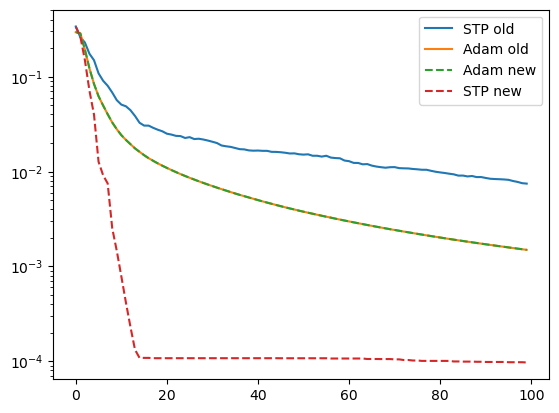

In [244]:
hist = classifier.logger['val_loss']
hist_adam = classifier_adam.logger['val_loss']

plt.semilogy(hist_tp_old['val_loss'], label='STP old')
plt.semilogy(hist_adam_old['val_loss'], label='Adam old')
plt.semilogy(hist_adam, label='Adam new', linestyle='--')
plt.semilogy(hist, label='STP new', linestyle='--')

plt.legend()

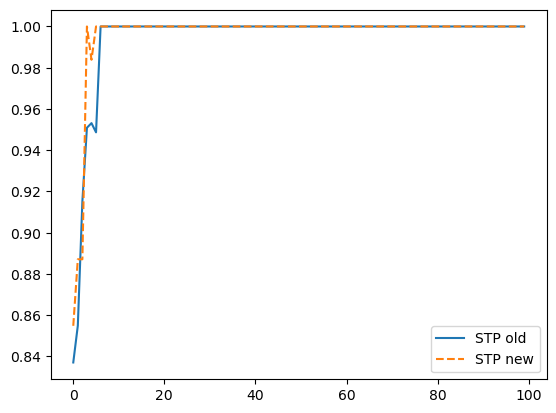

In [131]:
hist = classifier.logger['val_acc']
hist_adam = classifier_adam.logger['val_acc']

plt.plot(hist_tp_old['val_acc'], label='STP old')
# plt.plot(hist_adam_old['val_acc'], label='Adam old')
# plt.plot(hist_adam, label='Adam new', linestyle='--')
plt.plot(hist, label='STP new', linestyle='--')

plt.legend()

In [381]:
hist2['test/loss'][-1], hist[-1], test_f_star

(0.007463331611420094, 9.692586809945216e-05, 0.0005205630857871723)

In [16]:
def train_loop(datamodule, 
               n_epochs: int,
               optimizer: BaseOptimizer,
               seed: int = 0,
               **optimizer_kwargs) -> dict: 

    np.random.seed(seed)
    
    # params = np.zeros(train_data.shape[1])
    # params = np.random.randn(datamodule.num_features)
    model = NumpyLinearModel(input_dim=datamodule.num_features)
    
    optim = optimizer(model.params, **optimizer_kwargs)

    # oracle 
    loss_function = LegacyLogisticRegressionLoss(lmd=0.0)

    # logging 
    history = defaultdict(list)

    logger = NumpyLogger()
    
    for epoch in range(n_epochs):

        for batch in datamodule.train_dataloader:
            batch_data, batch_target = batch
        
            train_loss, train_grad, train_acc = loss_function.func_grad_acc(model.params, batch_data, batch_target)

            if optim.__class__.__name__ == "SLS":
                def closure(params):
                    return loss_function.func(params, batch_data, batch_target)
                optim.step(loss=train_loss, grad=train_grad, closure=closure)
            else:
                optim.step(loss=train_loss, grad=train_grad)
            
            g_norm_sq = np.linalg.norm(train_grad)**2
            history["train/batch/loss"].append(train_loss)
            history["train/batch/acc"].append(train_acc)
            history["train/batch/grad_norm_sq"].append(g_norm_sq)  

            history["lr"].append(optim.lr)

        logger.reset()
        for batch in datamodule.val_dataloader:
            batch_data, batch_target = batch
        
            # Test Evaluation 
            loss, grad, acc = loss_function.func_grad_acc(model.params, batch_data, batch_target)
            g_norm_sq = np.linalg.norm(grad)**2

            logger.log('val_loss', loss)
            logger.log('val_acc', acc)

        logger.compute_on_epoch()
        
    return logger

In [211]:
def twin_polyak_ma_new(datamodule, 
               n_epochs: int,
               seed: int = 0,
               beta: float = 0.9,
               eps: float = 1e-8,
               ) -> dict: 
    
    print("NEW!!")
    
    # np.random.seed(seed)

    # parameters
    model = [
        NumpyLinearModel(input_dim=datamodule.num_features),
        NumpyLinearModel(input_dim=datamodule.num_features)
    ]

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=0.0)
    metric_accuracy = LogisticRegressionAccuracy()
    
    # logging 
    history = defaultdict(list)
    logger = NumpyLogger()

    logger.log('model_x', model[0].params.copy(), on_epoch=False)
    logger.log('model_y', model[1].params.copy(), on_epoch=False)

        
    fm_x = 0.0
    gm_x = np.zeros_like(model[0].params)
    gamma_x = 0.0
    
    fm_y = 0.0
    gm_y = np.zeros_like(model[1].params)
    gamma_y = 0.0
        
    for epoch in range(n_epochs):
    
        for batch in datamodule.train_dataloader:
            X, y = batch    

            # print(X[0].todense())

            logits_x = model[0](X)  
            logits_y = model[1](X)  

            loss_x = loss_function.loss(logits_x, y, w=model[0].params)
            grad_x = loss_function.grad(logits_x, X, y, w=model[0].params)
        
            loss_y = loss_function.loss(logits_y, y, w=model[1].params)
            grad_y = loss_function.grad(logits_y, X, y, w=model[1].params)
            
            fm_x = beta * fm_x + (1 - beta) * loss_x
            gamma_x = beta * gamma_x + (1 - beta) * np.dot(grad_x, model[0].params)
            gm_x = beta * gm_x + (1 - beta) * grad_x
            h_x = fm_x + np.dot(gm_x, model[0].params) - gamma_x
            
            fm_y = beta * fm_y + (1 - beta) * loss_y
            gamma_y = beta * gamma_y + (1 - beta) * np.dot(grad_y, model[1].params)
            gm_y = beta * gm_y + (1 - beta) * grad_y
            h_y = fm_y + np.dot(gm_y, model[1].params) - gamma_y

            if h_x > h_y:
                diff = h_x - h_y
                lr_x = diff / (0.5 * np.square(np.linalg.norm(gm_x)) + eps) 
                model[0].params -= lr_x * gm_x
                lr = lr_x
                history["train/batch/loss"].append(loss_y)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_y)**2)
            else:
                diff = h_y - h_x
                lr_y = diff / (0.5 * np.square(np.linalg.norm(gm_y)) + eps)
                model[1].params -= lr_y * gm_y
                lr = lr_y
                history["train/batch/loss"].append(loss_x)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_x)**2)
            
            history["lr"].append(lr)
        
        # Test Evaluation     
        
        logger.reset()
        for batch in datamodule.train_dataloader:
            X, y = batch    

            logits_x = model[0](X)  
            logits_y = model[1](X)  

            loss_x = loss_function.loss(logits_x, y, w=model[0].params)
            grad_x = loss_function.grad(logits_x, X, y, w=model[0].params)
        
            loss_y = loss_function.loss(logits_y, y, w=model[1].params)
            grad_y = loss_function.grad(logits_y, X, y, w=model[1].params)
            
            if loss_x < loss_y:
                loss = loss_x
                acc = metric_accuracy(logits_x, y)
            else:
                loss = loss_y
                acc = metric_accuracy(logits_x, y)
            
            logger.log('val_loss', loss)
            logger.log('val_acc', acc)

        logger.compute_on_epoch()

    return logger

In [248]:
def twin_polyak_ma(datamodule, 
               n_epochs: int,
               seed: int = 0,
               beta: float = 0.9,
               eps: float = 1e-8,
               ) -> dict: 
    
    print("NEW")
    
    # parameters
    # params_x = np.random.randn(datamodule.num_features)
    # params_y = np.random.randn(datamodule.num_features)

    model_x = NumpyLinearModel(input_dim=datamodule.num_features)
    model_y = NumpyLinearModel(input_dim=datamodule.num_features)

    # model_y.params += 10

    # oracle 
    loss_function = LegacyLogisticRegressionLoss(lmd=0.0)
    
    # logging 
    history = defaultdict(list)
    logger = NumpyLogger()

    logger.log('model_x', model_x.params.copy(), on_epoch=False)
    logger.log('model_y', model_y.params.copy(), on_epoch=False)

        
    fm_x = 0.0
    gm_x = np.zeros_like(model_x.params)
    gamma_x = 0.0
    
    fm_y = 0.0
    gm_y = np.zeros_like(model_y.params)
    gamma_y = 0.0
        
    for epoch in range(n_epochs):
    
        for batch in datamodule.train_dataloader:
            batch_data, batch_target = batch        
            
            loss_x, grad_x, acc_x = loss_function.func_grad_acc(model_x.params, batch_data, batch_target)
            loss_y, grad_y, acc_y = loss_function.func_grad_acc(model_y.params, batch_data, batch_target)

            fm_x = beta * fm_x + (1 - beta) * loss_x
            gamma_x = beta * gamma_x + (1 - beta) * np.dot(grad_x, model_x.params)
            gm_x = beta * gm_x + (1 - beta) * grad_x
            h_x = fm_x + np.dot(gm_x, model_x.params) - gamma_x
            
            fm_y = beta * fm_y + (1 - beta) * loss_y
            gamma_y = beta * gamma_y + (1 - beta) * np.dot(grad_y, model_y.params)
            gm_y = beta * gm_y + (1 - beta) * grad_y
            h_y = fm_y + np.dot(gm_y, model_y.params) - gamma_y

            if h_x > h_y:
                diff = h_x - h_y
                lr_x = diff / (0.5 * np.square(np.linalg.norm(gm_x)) + eps) 
                model_x.params -= lr_x * gm_x
                lr = lr_x
                history["train/batch/loss"].append(loss_y)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_y)**2)
            else:
                diff = h_y - h_x
                lr_y = diff / (0.5 * np.square(np.linalg.norm(gm_y)) + eps)
                model_y.params -= lr_y * gm_y
                lr = lr_y
                history["train/batch/loss"].append(loss_x)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_x)**2)
            
            history["lr"].append(lr)
        
        # Test Evaluation     
        test_loss = []
        test_acc = []
        
        logger.reset()
        for batch in datamodule.train_dataloader:
            batch_data, batch_target = batch
            loss_x, grad_x, acc_x = loss_function.func_grad_acc(model_x.params, batch_data, batch_target)
            loss_y, grad_y, acc_y = loss_function.func_grad_acc(model_y.params, batch_data, batch_target)

            if loss_x < loss_y:
                loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
            else:
                loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
            # test_loss.append(loss)
            # test_acc.append(acc)

            logger.log('val_loss', loss)
            logger.log('val_acc', acc)

        logger.compute_on_epoch()

        # history["test/loss"].append(np.mean(test_loss))
        # history["test/acc"].append(np.mean(test_acc))
        # history["test/acc"].append(acc)
        # history["test/grad_norm_sq"].append(g_norm_sq)

    return logger

In [299]:
def twin_polyak(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0,
               eps: float = 0.0,
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset

    # parameters
    params_x = np.random.randn(train_data.shape[1])
    params_y = np.random.randn(train_data.shape[1])

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=0.0)
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Train Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, train_data, train_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["train/loss"].append(loss)
    history["train/acc"].append(acc)
    history["train/grad_norm_sq"].append(g_norm_sq)
    
    # Test Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)

    for epoch in range(n_epochs):
    
        # Training 
        if batch_size != train_data.shape[0]:
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            
            loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, batch_data, batch_target)
            loss_y, grad_y, acc_y  = loss_function.func_grad_acc(params_y, batch_data, batch_target)
            
            lr_x = (loss_x - loss_y) / (0.5 * np.square(np.linalg.norm(grad_x)) + eps) 
            lr_y = (loss_y - loss_x) / (0.5 * np.square(np.linalg.norm(grad_y)) + eps) 
            # Optimization step
            if loss_x > loss_y:
                params_x -= lr_x * grad_x
                lr = lr_x
            else:
                params_y -= lr_y * grad_y
                lr = lr_y
            
            history["bound_c"].append( np.abs(loss_x - loss_y) / (np.maximum(loss_x, loss_y) - train_f_star))
            history["bound_d"].append( (loss_y - train_f_star) / (loss_x - train_f_star) )
            history["bound_dd"].append( (np.minimum(loss_x, loss_y) - train_f_star) / (np.maximum(loss_x, loss_y) - train_f_star) )

            history["lr_x"].append(np.abs(lr_x))
            history["lr_y"].append(np.abs(lr_y))
            history["lr"].append(lr)
            
            
        # Train Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, train_data, train_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, train_data, train_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["train/loss"].append(loss)
        history["train/acc"].append(acc)
        history["train/grad_norm_sq"].append(g_norm_sq)
            
        # Test Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, test_data, test_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, test_data, test_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)

    return history

In [39]:
n_epochs = 50
seed = 0

histories = []
labels = []


hist_sgd = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=SGD,
                seed=seed, 
                lr=1/L,
                )
histories.append(hist_sgd)
if batch_size == train_data.shape[0]:
        labels.append("GD 1/L")
else:
        labels.append("SGD 1/L")
        
for eta_max in [1.0, 10.0, 20.0]:
# for eta_max in [0.0001, 0.001, 0.01, 0.1]:
        hist_sps = train_loop(dataset=dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=SPS,
                        seed=seed,
                        eta_max=eta_max,
                        eps=0.0,
                        )
        histories.append(hist_sps)
        labels.append(r"$SPS_{{max}} \gamma={0}$".format(eta_max))
        
hist_sls = train_loop(
        dataset=dataset,
        batch_size=batch_size,
        n_epochs=n_epochs,
        optimizer=SLS,
        seed=seed
        )
histories.append(hist_sls)
labels.append("SLS")

eta_max = 10.0
c_0 = 1.0
hist_sps = train_loop(dataset=dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=DecSPS,
                        seed=seed,
                        eta_max=eta_max,
                        c_0=c_0,
                        eps=0.0,
                        )
histories.append(hist_sps)
labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))
                
hist_twin = twin_polyak(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)

histories.append(hist_twin)
labels.append(r"$Twin Polyak$")


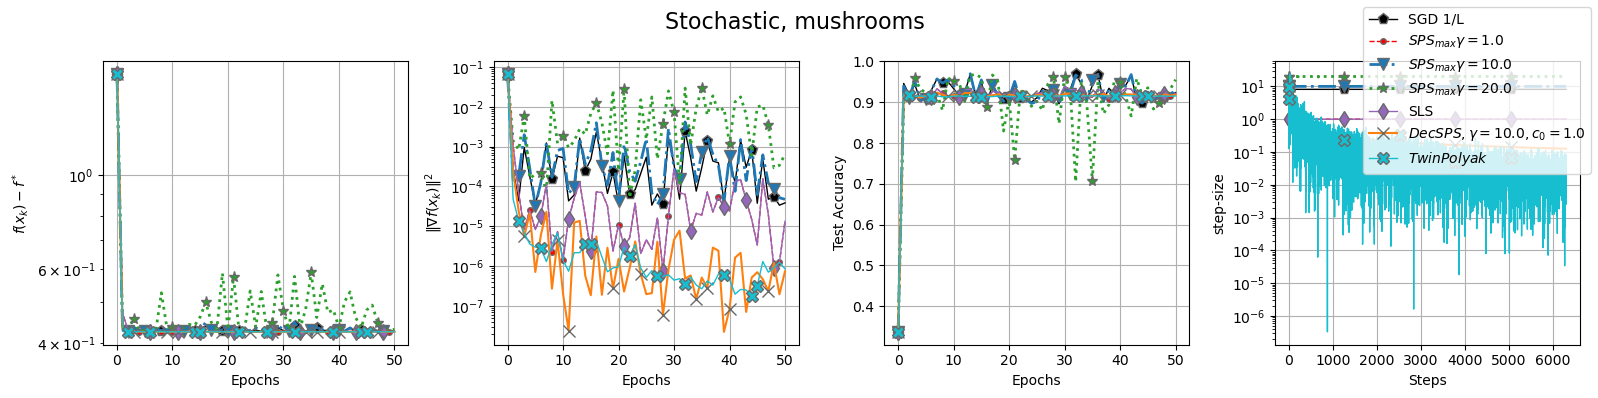

In [42]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.5, 1.0],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        suptitle=f"{setting}, {dataset_name}",
        prefix="train",
        threshold=0.0,
        apply_ma=False,
        # filename=f"rand_{dataset_name}_{setting.lower()}_logreg.pdf",
        )

In [ ]:
def twin_polyak_ma_WIP(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0,
               beta: float = 0.9,
               eps: float = 0.0,
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset

    # parameters
    params_x = np.random.randn(train_data.shape[1])
    params_y = np.random.randn(train_data.shape[1])

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=0.0)
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Train Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, train_data, train_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["train/loss"].append(loss)
    history["train/acc"].append(acc)
    history["train/grad_norm_sq"].append(g_norm_sq)
    
    # Test Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    fm_x = 0.0
    gm_x = np.zeros_like(params_x)
    gamma_x = 0.0
    
    fm_y = 0.0
    gm_y = np.zeros_like(params_y)
    gamma_y = 0.0
    
    # batch_size = int(train_data.shape[0] * 0.9)
    
    step_t = 0
    
    for epoch in range(n_epochs):
    
        # Training 
        if batch_size != train_data.shape[0]:
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            
            loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, batch_data, batch_target)
            loss_y, grad_y, acc_y  = loss_function.func_grad_acc(params_y, batch_data, batch_target)

            fm_x = beta * fm_x + (1 - beta) * loss_x
            gamma_x = beta * gamma_x + (1 - beta) * np.dot(grad_x, params_x)
            gm_x = beta * gm_x + (1 - beta) * grad_x
            h_x = fm_x + (np.dot(gm_x, params_x) - gamma_x)
            
            fm_y = beta * fm_y + (1 - beta) * loss_y
            gamma_y = beta * gamma_y + (1 - beta) * np.dot(grad_y, params_y)
            gm_y = beta * gm_y + (1 - beta) * grad_y
            h_y = fm_y + np.dot(gm_y, params_y) - gamma_y

            if h_x > h_y:
                diff = h_x - h_y
                lr_x = diff / (0.5 * np.square(np.linalg.norm(gm_x)) + eps) 
                params_x -= lr_x * gm_x
                lr = lr_x
                history["train/batch/loss"].append(loss_y)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_y)**2)
            else:
                diff = h_y - h_x
                lr_y = diff / (0.5 * np.square(np.linalg.norm(gm_y)) + eps)
                params_y -= lr_y * gm_y
                lr = lr_y
                history["train/batch/loss"].append(loss_x)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_x)**2)
            
            history["lr"].append(lr)
            
        # if (epoch + 1) % 20 == 0:
        #     batch_size = int(train_data.shape[0] * 0.1)
            
        # history["beta"].append(beta)
        # if (epoch + 1) % 20 == 0:
        #     if beta < 0.8:
        #         beta += 0.1
        #     else:
        #         beta = 0.9
        #     print(epoch, beta)
            
        # Train Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, train_data, train_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, train_data, train_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["train/loss"].append(loss)
        history["train/acc"].append(acc)
        history["train/grad_norm_sq"].append(g_norm_sq)
            
        # Test Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, test_data, test_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, test_data, test_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)

    return history

In [277]:
n_epochs = 100
seed = 0

histories = []
labels = []
beta = 0.9

for eta_max in [1.0, 5.0, 10.0, 20.0]:
        hist_sps = train_loop(dataset=dataset,
                        batch_size=batch_size,
                        n_epochs=n_epochs,
                        optimizer=SPS_MA,
                        seed=seed,
                        betas=(beta, beta),
                        eta_max=eta_max,
                        )
        histories.append(hist_sps)
        labels.append(r"$SPS_{{max}} MA, \eta_{{max}}={0}, \beta={1}$".format(eta_max, beta))

beta = 0.9
lr = 1.0
eps = 0.0
hist_momo = train_loop(dataset=dataset,
                batch_size=batch_size,
                n_epochs=n_epochs,
                optimizer=SGD_Momo,
                seed=seed,
                beta=beta,
                lr=lr,
                eps=eps
                )
histories.append(hist_momo)
labels.append(r"Momo, $\gamma_{{min}}={0}, \beta={1}$".format(lr, beta))

eps = 1e-6
for beta in [0.0, 0.9]:
        hist_twin_ma = twin_polyak_ma(dataset=dataset,
                        batch_size=batch_size,
                        n_epochs=n_epochs,
                        beta=beta,
                        eps=eps)

        histories.append(hist_twin_ma)
        labels.append(r"STP MA, $\beta={0}$".format(beta))

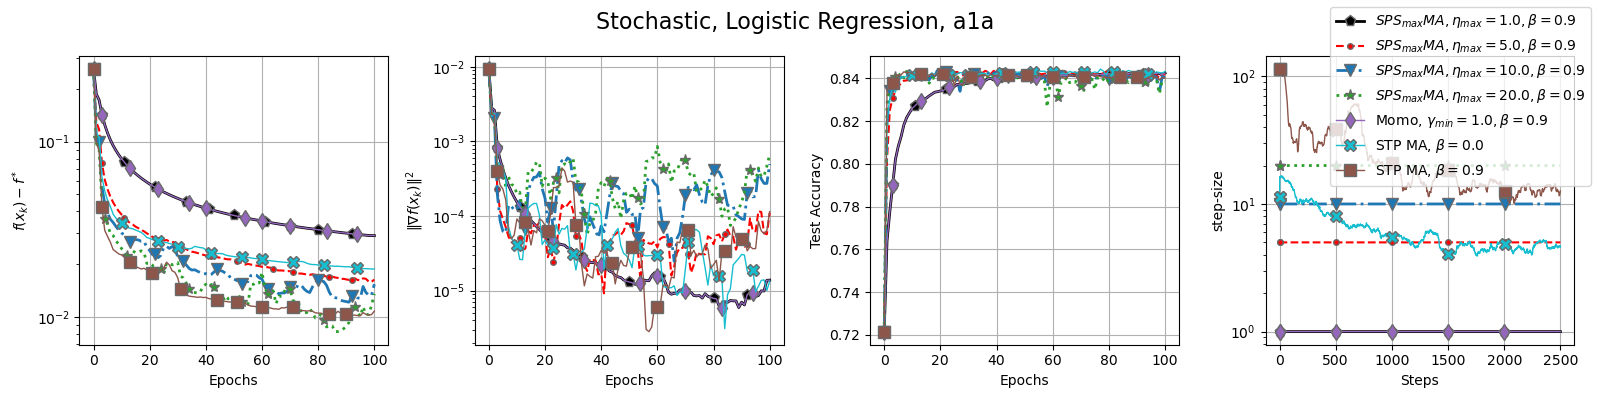

In [278]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:cyan", "tab:brown"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[2.0, 1.5, 2.0, 2.0, 1.0, 1.0, 1.0],
        markers=["p", ".", "v", "*", "d", "X", "s"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        suptitle=f"{setting}, Logistic Regression, {dataset_name}",
        prefix="train",
        threshold=0.0,
        # filename=f"momo-type-momentum_{dataset_name}.pdf",
        )